In [2]:
import cv2
import rasterio
import numpy as np
import json
import os
from matplotlib import pyplot as plt

## Create Mask and Normalize Images

In [5]:
def create_field_mask(image_shape, segmentation):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    points = np.array(segmentation, dtype=np.int32).reshape(-1, 2)
    cv2.fillPoly(mask, [points], 1)  # Fill the polygon with 1s
    return mask

def create_edge_mask(image_shape, segmentation, thickness=1):
    edge_mask = np.zeros(image_shape[:2], dtype=np.uint8)
    contour = np.array(segmentation, dtype=np.int32).reshape(-1, 2)
    cv2.drawContours(edge_mask, [contour], contourIdx=-1, color=1, thickness=thickness)
    return edge_mask

In [11]:
images_dir = "dataset/train_images/"
images_norm_12_dir = "dataset/train_images_norm_12/"
images_norm_6_dir = "dataset/train_images_norm_6/"
field_mask_dir = "dataset/train_field_mask/"
edge_mask_dir = "dataset/train_edge_mask/"
combined_mask_dir = "dataset/train_combined_mask/"

In [25]:
# with rasterio.open("dataset/train_images/train_0.tif") as src:
#     image = src.read()
#     image1 = src.read(2)
#     image2 = src.read(3)
#     image3 = src.read(4)

In [37]:
def create_data_preprocess(data, with_images=True, bands=[i for i in range(12)]):
    for image_data in data["images"]:
        file_name = image_data["file_name"]
        image_path = os.path.join(images_dir, file_name)
        
        with rasterio.open(image_path) as src:
            image = np.stack([src.read(band) for band in bands])
        equalized_bands = []
        for band in range(image.shape[2]):
            band_image = image[:,:,band]
            #min max scaller
            band_image = np.nan_to_num(band_image, nan=0.0, posinf=255.0, neginf=0.0)
            band_image = np.array((band_image - band_image.min()) / (band_image.max() - band_image.min()))
            band_image = (band_image * 255).astype(np.uint8)
            #his eq
            equalized_band = cv2.equalizeHist(band_image)
            equalized_band = equalized_band / 255.
            equalized_bands.append(equalized_band)

        #save images norm
        image = np.stack(equalized_bands, axis=-1)
        image = np.transpose(image, (1, 2, 0))
        print(image.shape)
        if (with_images): np.save(images_norm_12_dir+file_name+".npy", image)
        
        # width, height = image.shape[:2]
        # field_masks = np.zeros((width, height), dtype=np.float16)
        # edge_masks = np.zeros((width, height), dtype=np.float16)
        
        # for annotation in image_data["annotations"]:
        #     segmentation = annotation["segmentation"]
        #     field_mask = create_field_mask((width, height), segmentation)
        #     field_masks = np.maximum(field_masks, field_mask)
        #     edge_mask = create_edge_mask((width, height), segmentation)
        #     edge_masks = np.maximum(edge_masks, edge_mask)
        # np.save(field_mask_dir+file_name+"_field_mask.npy", field_masks)
        # np.save(edge_mask_dir+file_name+"_edge_mask.npy", edge_masks)

In [27]:
with open("dataset/train_annotation.json", "r") as f:
    data = json.load(f)

In [38]:
create_data_preprocess(data, bands=[1,2,3,4,5,6,7,8,9,10,11,12])

(804, 981, 12)
(803, 1008, 12)
(804, 978, 12)
(804, 952, 12)
(802, 1199, 12)
(802, 1206, 12)
(803, 1067, 12)
(803, 1065, 12)
(802, 1170, 12)
(803, 1053, 12)
(804, 976, 12)
(802, 1194, 12)
(804, 984, 12)
(804, 928, 12)
(803, 1061, 12)
(804, 953, 12)
(801, 1254, 12)
(801, 1324, 12)
(803, 1002, 12)
(804, 948, 12)
(803, 1039, 12)
(804, 930, 12)
(805, 882, 12)
(804, 909, 12)
(801, 1288, 12)
(802, 1198, 12)
(804, 980, 12)
(803, 1036, 12)
(802, 1179, 12)
(802, 1314, 12)
(802, 1167, 12)
(804, 928, 12)
(802, 1179, 12)
(804, 929, 12)
(805, 836, 12)
(803, 1090, 12)
(803, 1053, 12)
(803, 995, 12)
(804, 1034, 12)
(802, 1288, 12)
(802, 1176, 12)
(805, 914, 12)
(803, 1063, 12)
(804, 904, 12)
(802, 1082, 12)
(801, 1195, 12)
(804, 989, 12)
(801, 1293, 12)
(803, 1061, 12)
(802, 1169, 12)


## Inspect Data Preprocessing

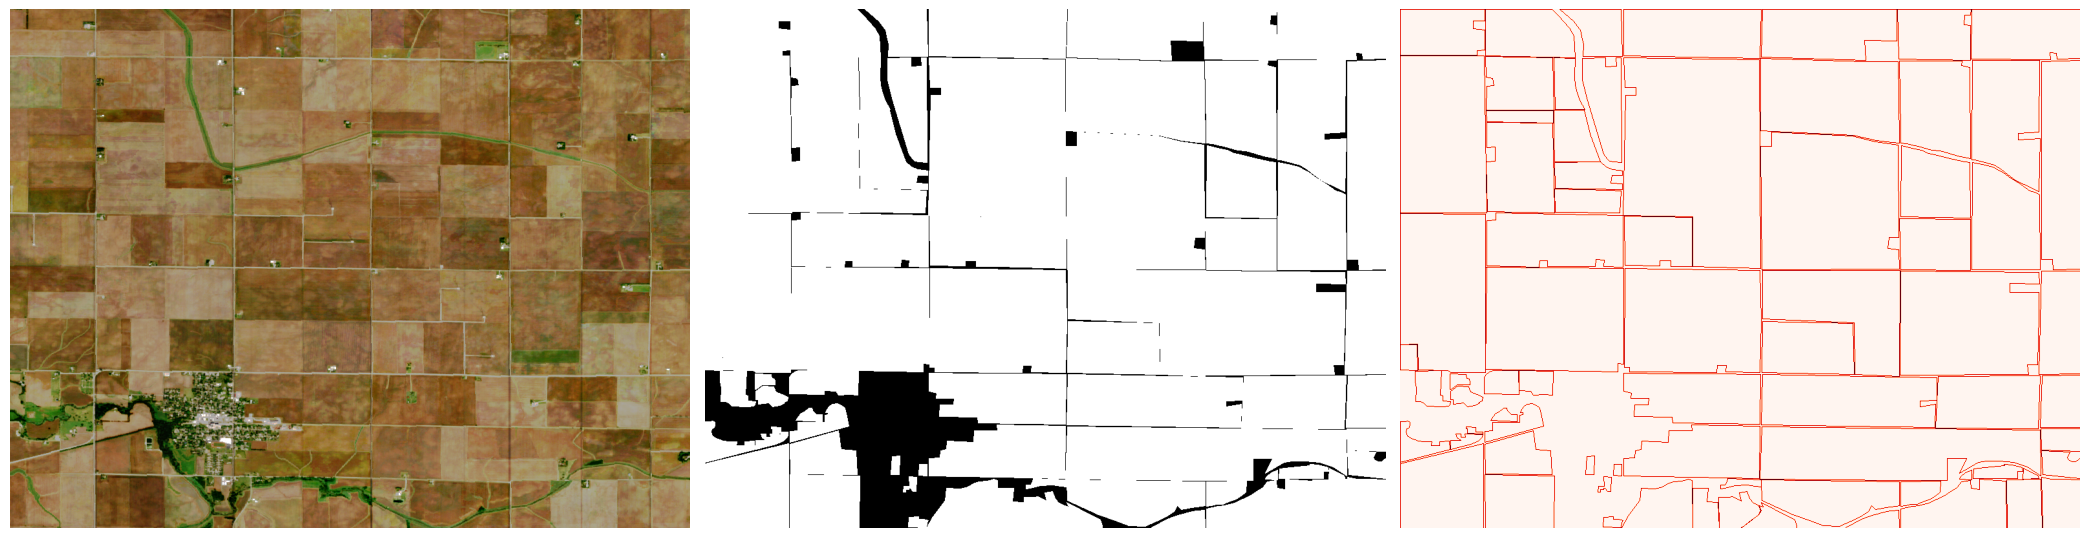

1.0 1.0 1.0


In [69]:
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
ax = ax.flatten()

loaded_image = np.load("dataset/train_images_norm_6/train_9.tif.npy")
loaded_image = np.stack((loaded_image[:, :, 3], loaded_image[:, :, 2], loaded_image[:, :, 1]))
loaded_image = np.transpose(loaded_image, (1, 2, 0))
loaded_field_mask = np.load("dataset/train_field_mask/train_9.tif_field_mask.npy")
loaded_edge_mask = np.load("dataset/train_edge_mask/train_9.tif_edge_mask.npy")

ax[0].imshow(loaded_image)
ax[0].axis("off")
ax[1].imshow(loaded_field_mask, cmap="grey")
ax[1].axis("off")
ax[2].imshow(loaded_edge_mask, cmap="Reds")
ax[2].axis("off")
plt.tight_layout()
plt.show()

print(np.max(loaded_image), np.max(loaded_field_mask), np.max(loaded_edge_mask))

## Combining Mask

In [204]:
for i in range(50):
    mask_field = np.load(f"dataset/train_field_mask/train_{i}.tif_field_mask.npy")
    mask_edge = np.load(f"dataset/train_edge_mask/train_{i}.tif_edge_mask.npy")
    
    assert mask_field.shape == mask_edge.shape, "Ukuran kedua mask harus sama"
    
    combined_mask = np.zeros_like(mask_field, dtype=np.uint8)
    combined_mask[mask_field == 1.0] = 1  # Field -> Class 1
    combined_mask[mask_edge == 1.0] = 2    # Edge -> Class 2
    
    combined_mask_tf = np.expand_dims(combined_mask, axis=-1)
    np.save(combined_mask_dir+f"train_combined_mask_{i}.npy", combined_mask_tf)

[0 1 2]


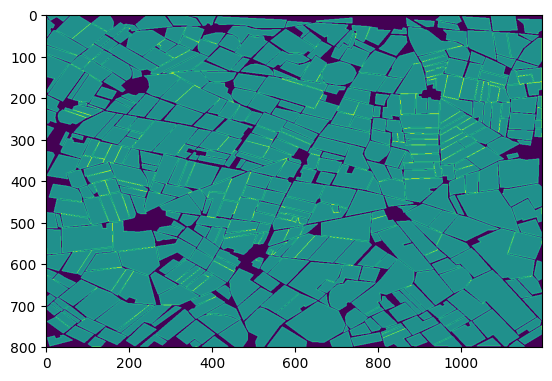

In [210]:
test_combined_mask = np.load(combined_mask_dir+"train_combined_mask_45.npy")

plt.imshow(test_combined_mask)
print(np.unique(test_combined_mask))